# YOLO データセット分割結果の検証
**このノートブックを実行するときはvenvで別の仮想環境を作ってください**  
必要なライブラリ：opencv-python matplotlib numpy

このノートブックは、YOLOアノテーターで作成されたデータセット分割の結果を視覚的に確認するためのツールです。

## 機能
- output/images/ フォルダ内の画像を読み込み
- 対応するYOLO形式のアノテーションファイル（.txt）を解析
- バウンディングボックスを画像上に描画して表示
- train/valid セットの分割結果を検証

## 使用方法
1. 必要なライブラリをインストール
2. 各セルを順番に実行
3. 画像とアノテーションの対応関係を確認

In [112]:
# 必要なライブラリのインポート
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from pathlib import Path
import glob
from typing import List, Tuple, Dict, Optional

# 日本語フォントの設定（Matplotlib用）
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)

print("ライブラリのインポートが完了しました。")

ライブラリのインポートが完了しました。


In [113]:
os.getcwd()

'c:\\Users\\A067214\\Desktop\\workspace\\yolo_annotator'

In [114]:
# 設定とヘルパー関数の定義

# データセットのパス設定
OUTPUT_DIR = Path("output")
IMAGES_DIR = OUTPUT_DIR / "**" / "images"
LABELS_DIR = OUTPUT_DIR / "**" / "labels"


In [126]:
# クラス名の定義（実際のプロジェクトに合わせて変更してください）
CLASS_NAMES = {
    0: "class_0",
    1: "class_1", 
    2: "class_2",
    3: "class_3",
    4: "class_4",
    5: "class_5",
    6: "class_6",
    7: "class_7",
    8: "class_8",
    9: "class_9",
    10: "class_10",
    11: "class_11"
}

# カラーパレット（各クラス用）
COLORS = [
    '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF',
    '#800000', '#008000', '#000080', '#808000', '#800080', '#008080'
]

def read_yolo_annotation(annotation_path) -> List[Tuple[int, float, float, float, float]]:
    """
    YOLO形式のアノテーションファイルを読み込む
    
    Args:
        annotation_path: アノテーションファイルのパス（文字列またはPathオブジェクト）
        
    Returns:
        List of (class_id, x_center, y_center, width, height) tuples
    """
    annotations = []
    
    # 文字列でもPathオブジェクトでも対応できるようにPathに変換
    annotation_path = Path(annotation_path)
    print(f"Reading annotations from {annotation_path}")

    
    if not annotation_path.exists():
        print(f"  ⚠️ ファイルが存在しません: {annotation_path}")
        return annotations
        
    try:
        with open(annotation_path, 'r') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])
                        annotations.append((class_id, x_center, y_center, width, height))
        print(f"  ✅ {len(annotations)} 個のアノテーションを読み込みました")
    except Exception as e:
        print(f"  ❌ Error reading annotation file {annotation_path}: {e}")
    
    return annotations

def yolo_to_bbox(x_center: float, y_center: float, width: float, height: float, 
                img_width: int, img_height: int) -> Tuple[int, int, int, int]:
    """
    YOLO形式の正規化座標をピクセル座標のバウンディングボックスに変換
    
    Args:
        x_center, y_center, width, height: YOLO形式の正規化座標
        img_width, img_height: 画像のサイズ
        
    Returns:
        (x_min, y_min, x_max, y_max) in pixel coordinates
    """
    x_center_px = x_center * img_width
    y_center_px = y_center * img_height
    width_px = width * img_width
    height_px = height * img_height
    
    x_min = int(x_center_px - width_px / 2)
    y_min = int(y_center_px - height_px / 2)
    x_max = int(x_center_px + width_px / 2)
    y_max = int(y_center_px + height_px / 2)
    
    return x_min, y_min, x_max, y_max

print("設定とヘルパー関数の定義が完了しました。")

設定とヘルパー関数の定義が完了しました。


In [127]:
# データセットの概要確認

def scan_dataset() -> Dict:
    """データセットの構造と統計情報を取得"""
    dataset_info = {
        'train': {'images': [], 'labels': [], 'image_count': 0, 'label_count': 0},
        'valid': {'images': [], 'labels': [], 'image_count': 0, 'label_count': 0}
    }

    # output/ディレクトリ内の実際の構造を動的に検索
    if not OUTPUT_DIR.exists():
        print(f"⚠️ {OUTPUT_DIR} ディレクトリが存在しません")
        return dataset_info
    
    # output/内のサブディレクトリを検索
    output_subdirs = [d for d in OUTPUT_DIR.iterdir() if d.is_dir()]
    
    if not output_subdirs:
        print(f"⚠️ {OUTPUT_DIR} 内にサブディレクトリが見つかりません")
        return dataset_info
    
    # 最新のoutputディレクトリを使用（名前でソート）
    latest_output_dir = sorted(output_subdirs)[-1]
    print(f"📁 使用するディレクトリ: {latest_output_dir}")

    for split in ['train', 'valid']:
        print(f"🔍 Scanning {split} dataset...")
        
        # 画像ディレクトリとラベルディレクトリのパス
        image_dir = latest_output_dir / "images" / split
        label_dir = latest_output_dir / "labels" / split
        
        print(f"  画像ディレクトリ: {image_dir}")
        print(f"  ラベルディレクトリ: {label_dir}")
        
        # 画像ファイルをスキャン
        if image_dir.exists():
            image_patterns = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
            for pattern in image_patterns:
                images = list(image_dir.glob(pattern))
                dataset_info[split]['images'].extend([str(img) for img in images])
            dataset_info[split]['image_count'] = len(dataset_info[split]['images'])
            print(f"  📷 画像ファイル: {dataset_info[split]['image_count']} 件")
        else:
            print(f"  ⚠️ 画像ディレクトリが存在しません: {image_dir}")
        
        # ラベルファイルをスキャン
        if label_dir.exists():
            labels = list(label_dir.glob('*.txt'))
            # .gitkeepファイルを除外
            labels = [str(l) for l in labels if l.name != '.gitkeep']
            dataset_info[split]['labels'] = labels
            dataset_info[split]['label_count'] = len(labels)
            print(f"  🏷️ ラベルファイル: {dataset_info[split]['label_count']} 件")
        else:
            print(f"  ⚠️ ラベルディレクトリが存在しません: {label_dir}")
    
    return dataset_info

# データセット情報を取得
dataset_info = scan_dataset()

print("\n" + "="*50)
# 統計情報を表示
print("=== データセット分割結果 ===")
print(f"Training Set:")
print(f"  画像ファイル数: {dataset_info['train']['image_count']}")
print(f"  ラベルファイル数: {dataset_info['train']['label_count']}")

print(f"\nValidation Set:")
print(f"  画像ファイル数: {dataset_info['valid']['image_count']}")
print(f"  ラベルファイル数: {dataset_info['valid']['label_count']}")

print(f"\n合計:")
total_images = dataset_info['train']['image_count'] + dataset_info['valid']['image_count']
total_labels = dataset_info['train']['label_count'] + dataset_info['valid']['label_count']
print(f"  画像ファイル数: {total_images}")
print(f"  ラベルファイル数: {total_labels}")

if total_images > 0:
    train_ratio = dataset_info['train']['image_count'] / total_images * 100
    valid_ratio = dataset_info['valid']['image_count'] / total_images * 100
    print(f"\n分割比率:")
    print(f"  Training: {train_ratio:.1f}%")
    print(f"  Validation: {valid_ratio:.1f}%")

📁 使用するディレクトリ: output\output_20250702_151005
🔍 Scanning train dataset...
  画像ディレクトリ: output\output_20250702_151005\images\train
  ラベルディレクトリ: output\output_20250702_151005\labels\train
  📷 画像ファイル: 14 件
  🏷️ ラベルファイル: 7 件
🔍 Scanning valid dataset...
  画像ディレクトリ: output\output_20250702_151005\images\valid
  ラベルディレクトリ: output\output_20250702_151005\labels\valid
  📷 画像ファイル: 2 件
  🏷️ ラベルファイル: 1 件

=== データセット分割結果 ===
Training Set:
  画像ファイル数: 14
  ラベルファイル数: 7

Validation Set:
  画像ファイル数: 2
  ラベルファイル数: 1

合計:
  画像ファイル数: 16
  ラベルファイル数: 8

分割比率:
  Training: 87.5%
  Validation: 12.5%


In [117]:
(dataset_info['train']['images'])
LABELS_DIR

WindowsPath('output/**/labels')

In [125]:
# デバッグ: パス構造の確認
print("=== パス構造の確認 ===")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"IMAGES_DIR: {IMAGES_DIR}")
print(f"LABELS_DIR: {LABELS_DIR}")

# 実際のディレクトリ構造を確認
import os
print(f"\noutput/ ディレクトリの内容:")
if OUTPUT_DIR.exists():
    for item in OUTPUT_DIR.iterdir():
        if item.is_dir():
            print(f"  📁 {item.name}/")
            # サブディレクトリの内容も確認
            for subitem in item.iterdir():
                if subitem.is_dir():
                    print(f"    📁 {subitem.name}/")
                    # さらにサブディレクトリがあれば確認
                    try:
                        for subsubitem in subitem.iterdir():
                            if subsubitem.is_dir():
                                print(f"      📁 {subsubitem.name}/")
                            else:
                                print(f"      📄 {subsubitem.name}")
                    except:
                        pass
                else:
                    print(f"    📄 {subitem.name}")
        else:
            print(f"  📄 {item.name}")
else:
    print("  output/ ディレクトリが存在しません")

# dataset_info の内容確認
print(f"\n=== dataset_info の内容 ===")
for split in ['train', 'valid']:
    print(f"{split}:")
    print(f"  images: {len(dataset_info[split]['images'])} 件")
    if dataset_info[split]['images']:
        print(f"    例: {dataset_info[split]['images'][0]}")
    print(f"  labels: {len(dataset_info[split]['labels'])} 件")
    if dataset_info[split]['labels']:
        print(f"    例: {dataset_info[split]['labels'][0]}")
        print(f"    型: {type(dataset_info[split]['labels'][0])}")

=== パス構造の確認 ===
OUTPUT_DIR: output
IMAGES_DIR: output\**\images
LABELS_DIR: output\**\labels

output/ ディレクトリの内容:
  📁 output_20250702_151005/
    📄 dataset_1280x1280_20250702_151005.yaml
    📁 images/
      📁 train/
      📁 valid/
    📁 labels/
      📁 train/
      📁 valid/

=== dataset_info の内容 ===
train:
  images: 7 件
    例: output\output_20250702_151005\images\train\snap_2025-06-18_11-27-20.png
  labels: 7 件
    例: output\output_20250702_151005\labels\train\snap_2025-06-18_11-27-20.txt
    型: <class 'str'>
valid:
  images: 1 件
    例: output\output_20250702_151005\images\valid\snap_2025-06-18_11-52-24.png
  labels: 1 件
    例: output\output_20250702_151005\labels\valid\snap_2025-06-18_11-52-24.txt
    型: <class 'str'>


In [128]:
# アノテーション内容の分析

def analyze_annotations(dataset_info: Dict) -> Dict:
    """アノテーション内容を分析"""
    analysis = {
        'train': {'class_counts': {}, 'total_objects': 0, 'files_with_annotations': 0},
        'valid': {'class_counts': {}, 'total_objects': 0, 'files_with_annotations': 0}
    }
    
    for split in ['train', 'valid']:
        for label_file in dataset_info[split]['labels']:
            annotations = read_yolo_annotation(label_file)
            
            if annotations:
                analysis[split]['files_with_annotations'] += 1
                
            for class_id, _, _, _, _ in annotations:
                analysis[split]['total_objects'] += 1
                if class_id not in analysis[split]['class_counts']:
                    analysis[split]['class_counts'][class_id] = 0
                analysis[split]['class_counts'][class_id] += 1
    
    return analysis

# アノテーション分析を実行
annotation_analysis = analyze_annotations(dataset_info)

print("=== アノテーション分析結果 ===")
for split in ['train', 'valid']:
    print(f"\n{split.capitalize()} Set:")
    print(f"  アノテーション付きファイル数: {annotation_analysis[split]['files_with_annotations']}")
    print(f"  総オブジェクト数: {annotation_analysis[split]['total_objects']}")
    
    if annotation_analysis[split]['class_counts']:
        print(f"  クラス別オブジェクト数:")
        for class_id, count in sorted(annotation_analysis[split]['class_counts'].items()):
            class_name = CLASS_NAMES.get(class_id, f"Unknown_{class_id}")
            print(f"    クラス {class_id} ({class_name}): {count}")
    else:
        print(f"  アノテーションが見つかりませんでした。")

# 全体のクラス分布を確認
all_classes = set()
for split in ['train', 'valid']:
    all_classes.update(annotation_analysis[split]['class_counts'].keys())

if all_classes:
    print(f"\n=== 全体のクラス分布 ===")
    for class_id in sorted(all_classes):
        train_count = annotation_analysis['train']['class_counts'].get(class_id, 0)
        valid_count = annotation_analysis['valid']['class_counts'].get(class_id, 0)
        total_count = train_count + valid_count
        class_name = CLASS_NAMES.get(class_id, f"Unknown_{class_id}")
        print(f"クラス {class_id} ({class_name}): Train={train_count}, Valid={valid_count}, Total={total_count}")

Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-27-20.txt
  ✅ 5 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-32-21.txt
  ✅ 4 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-42-22.txt
  ✅ 7 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-47-23.txt
  ✅ 6 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-57-24.txt
  ✅ 5 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_12-02-25.txt
  ✅ 3 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_12-07-25.txt
  ✅ 1 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\valid\snap_2025-06-18_11-52-24.txt
  ✅ 5 個のアノテーションを読み込みました
=== アノテーション分析結果 ===

Train Set:


In [129]:
# 画像とアノテーションの可視化関数

def get_latest_output_dir():
    """最新のoutputディレクトリを取得"""
    if not OUTPUT_DIR.exists():
        return None
    output_subdirs = [d for d in OUTPUT_DIR.iterdir() if d.is_dir()]
    if not output_subdirs:
        return None
    return sorted(output_subdirs)[-1]

def visualize_image_with_annotations(image_path, split: str, ax=None, show_details=True):
    """
    画像とそのアノテーションを可視化
    
    Args:
        image_path: 画像ファイルのパス（文字列またはPathオブジェクト）
        split: 'train' または 'valid'
        ax: matplotlib axis (None の場合は新しいfigureを作成)
        show_details: 詳細情報を表示するかどうか
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # パスを適切に処理
    image_path = Path(image_path)
    
    # 画像を読み込み
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            ax.text(0.5, 0.5, f'画像を読み込めませんでした:\\n{image_path.name}', 
                   transform=ax.transAxes, ha='center', va='center')
            return
            
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width = image_rgb.shape[:2]
        
        # 画像を表示
        ax.imshow(image_rgb)
        
        # 対応するアノテーションファイルを探す
        latest_output_dir = get_latest_output_dir()
        if latest_output_dir:
            label_path = latest_output_dir / "labels" / split / (image_path.stem + '.txt')
        else:
            label_path = LABELS_DIR / split / (image_path.stem + '.txt')
            
        annotations = read_yolo_annotation(label_path)
        
        # バウンディングボックスを描画
        for i, (class_id, x_center, y_center, width, height) in enumerate(annotations):
            # YOLO座標をピクセル座標に変換
            x_min, y_min, x_max, y_max = yolo_to_bbox(
                x_center, y_center, width, height, img_width, img_height
            )
            
            # バウンディングボックスを描画
            color = COLORS[class_id % len(COLORS)]
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            
            # クラスラベルを表示
            class_name = CLASS_NAMES.get(class_id, f"Class_{class_id}")
            ax.text(x_min, y_min - 5, f'{class_name}', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.7),
                   fontsize=8, color='white', weight='bold')
        
        # タイトルと詳細情報を設定
        title = f'{image_path.name} ({split})'
        if show_details:
            title += f'\\nObjects: {len(annotations)}, Size: {img_width}x{img_height}'
        ax.set_title(title, fontsize=10)
        ax.axis('off')
        
    except Exception as e:
        ax.text(0.5, 0.5, f'エラー: {str(e)}', 
               transform=ax.transAxes, ha='center', va='center')
        ax.set_title(f'Error loading {image_path.name}')

def display_sample_images(split: str, max_images: int = 6):
    """
    指定されたsplitからサンプル画像を表示
    
    Args:
        split: 'train' または 'valid'
        max_images: 表示する最大画像数
    """
    images = dataset_info[split]['images'][:max_images]
    
    if not images:
        print(f"{split} セットに画像が見つかりませんでした。")
        return
    
    # グリッドサイズを計算
    n_images = len(images)
    cols = min(3, n_images)
    rows = (n_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if hasattr(axes, '__iter__') else [axes]
    else:
        axes = axes.flatten()
    
    for i, image_path in enumerate(images):
        visualize_image_with_annotations(image_path, split, axes[i])
    
    # 余った軸を非表示
    for i in range(n_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("可視化関数の定義が完了しました。")

可視化関数の定義が完了しました。


=== Training Set のサンプル画像 ===
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-27-20.txt
  ✅ 5 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-32-21.txt
  ✅ 4 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-42-22.txt
  ✅ 7 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-47-23.txt
  ✅ 6 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-57-24.txt
  ✅ 5 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_12-02-25.txt
  ✅ 3 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_12-02-25.txt
  ✅ 3 個のアノテーションを読み込みました


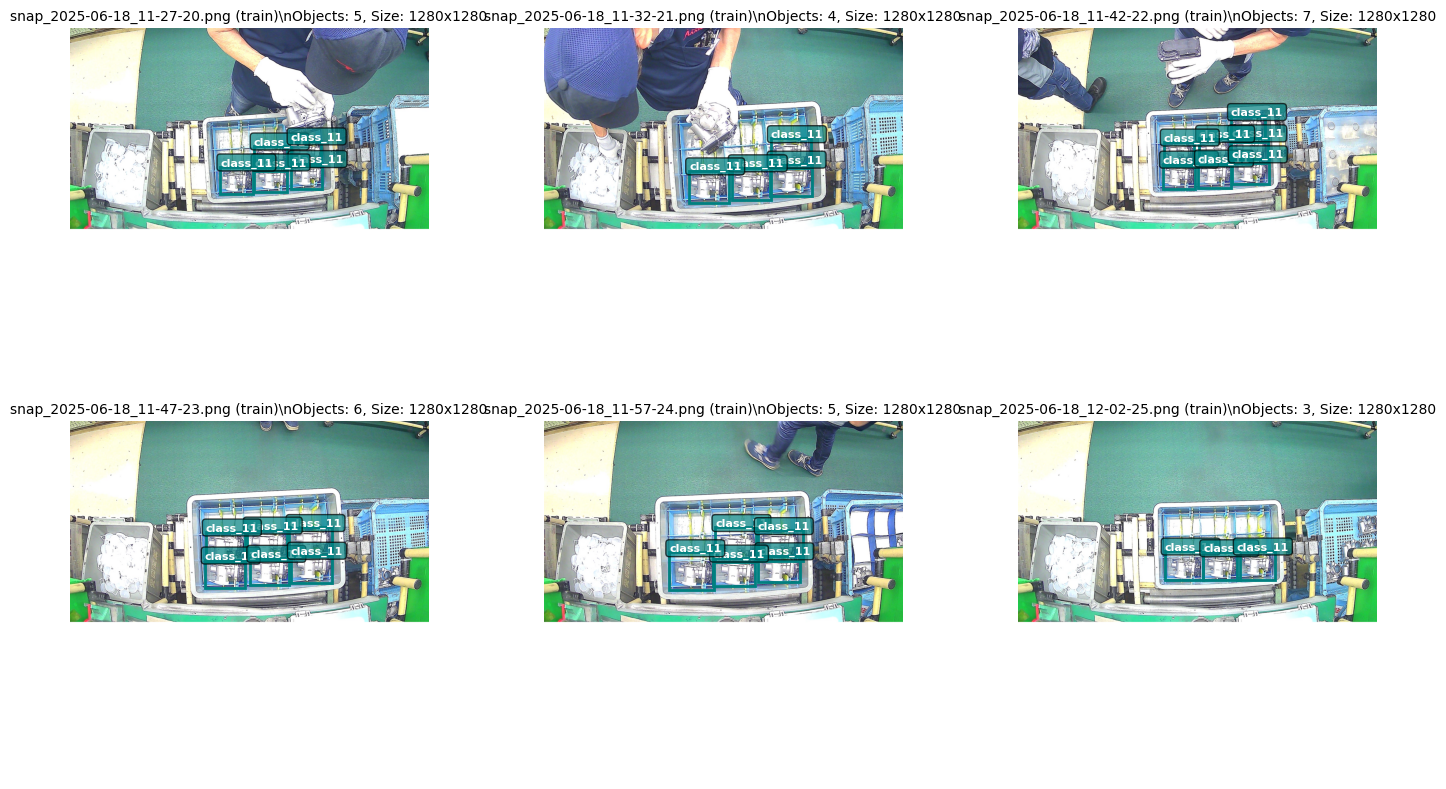

In [130]:
# Training セットのサンプル画像表示

print("=== Training Set のサンプル画像 ===")
display_sample_images('train', max_images=6)

=== Validation Set のサンプル画像 ===
Reading annotations from output\output_20250702_151005\labels\valid\snap_2025-06-18_11-52-24.txt
  ✅ 5 個のアノテーションを読み込みました
Reading annotations from output\output_20250702_151005\labels\valid\snap_2025-06-18_11-52-24.txt
  ✅ 5 個のアノテーションを読み込みました


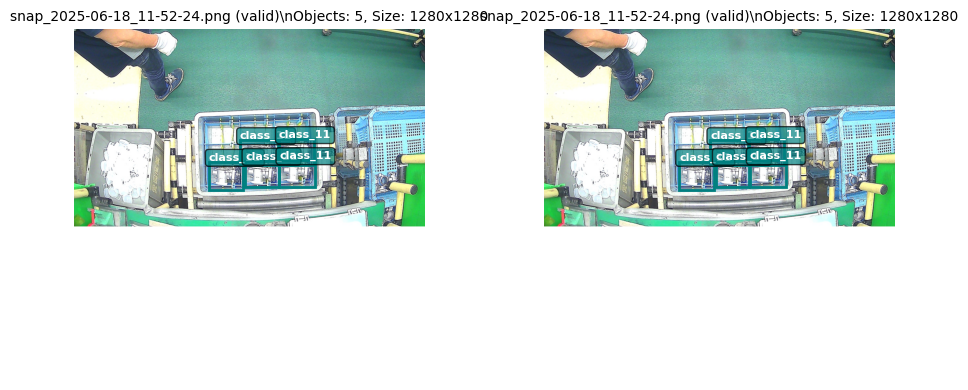

In [131]:
# Validation セットのサンプル画像表示

print("=== Validation Set のサンプル画像 ===")
display_sample_images('valid', max_images=6)

In [132]:
# ファイル対応関係の検証

def verify_file_matching(dataset_info: Dict):
    """画像ファイルとラベルファイルの対応関係を検証"""
    print("=== ファイル対応関係の検証 ===")
    
    for split in ['train', 'valid']:
        print(f"\\n{split.capitalize()} Set:")
        
        # 画像ファイル名のセット（拡張子なし）
        image_stems = {Path(img).stem for img in dataset_info[split]['images']}
        
        # ラベルファイル名のセット（拡張子なし）
        label_stems = {Path(lbl).stem for lbl in dataset_info[split]['labels']}
        
        # 対応関係を確認
        images_without_labels = image_stems - label_stems
        labels_without_images = label_stems - image_stems
        matched_files = image_stems & label_stems
        
        print(f"  対応する画像-ラベルペア: {len(matched_files)}")
        
        if images_without_labels:
            print(f"  ラベルがない画像ファイル: {len(images_without_labels)}")
            for stem in sorted(list(images_without_labels)[:5]):  # 最初の5件のみ表示
                print(f"    - {stem}")
            if len(images_without_labels) > 5:
                print(f"    ... その他 {len(images_without_labels) - 5} 件")
        
        if labels_without_images:
            print(f"  画像がないラベルファイル: {len(labels_without_images)}")
            for stem in sorted(list(labels_without_images)[:5]):  # 最初の5件のみ表示
                print(f"    - {stem}")
            if len(labels_without_images) > 5:
                print(f"    ... その他 {len(labels_without_images) - 5} 件")
        
        # マッチング率を計算
        total_unique_files = len(image_stems | label_stems)
        if total_unique_files > 0:
            matching_rate = len(matched_files) / total_unique_files * 100
            print(f"  ファイル対応率: {matching_rate:.1f}%")

# ファイル対応関係を検証
verify_file_matching(dataset_info)

=== ファイル対応関係の検証 ===
\nTrain Set:
  対応する画像-ラベルペア: 7
  ファイル対応率: 100.0%
\nValid Set:
  対応する画像-ラベルペア: 1
  ファイル対応率: 100.0%


In [133]:
# 個別画像の詳細確認

def inspect_specific_image(image_name: str, split: str = None):
    """
    特定の画像とそのアノテーションを詳細に確認
    
    Args:
        image_name: 画像ファイル名（拡張子あり/なし両方対応）
        split: 'train', 'valid', または None（両方を検索）
    """
    if split:
        splits_to_check = [split]
    else:
        splits_to_check = ['train', 'valid']
    
    found = False
    
    for check_split in splits_to_check:
        for image_path_str in dataset_info[check_split]['images']:
            image_path = Path(image_path_str)
            if image_name in [image_path.name, image_path.stem]:
                found = True
                print(f"=== {image_path.name} ({check_split} set) ===")
                
                # 画像情報を表示
                try:
                    image = cv2.imread(str(image_path))
                    if image is not None:
                        height, width = image.shape[:2]
                        print(f"画像サイズ: {width} x {height}")
                        file_size = image_path.stat().st_size / 1024
                        print(f"ファイルサイズ: {file_size:.1f} KB")
                except Exception as e:
                    print(f"画像情報の取得に失敗しました: {e}")
                
                # アノテーション情報を表示
                latest_output_dir = get_latest_output_dir()
                if latest_output_dir:
                    label_path = latest_output_dir / "labels" / check_split / (image_path.stem + '.txt')
                else:
                    label_path = LABELS_DIR / check_split / (image_path.stem + '.txt')
                    
                print(f"アノテーションファイル: {label_path}")
                annotations = read_yolo_annotation(label_path)
                print(f"アノテーション数: {len(annotations)}")
                
                if annotations:
                    print("オブジェクト詳細:")
                    for i, (class_id, x_center, y_center, width, height) in enumerate(annotations):
                        class_name = CLASS_NAMES.get(class_id, f"Unknown_{class_id}")
                        print(f"  {i+1}. クラス: {class_id} ({class_name})")
                        print(f"     中心座標: ({x_center:.3f}, {y_center:.3f})")
                        print(f"     サイズ: {width:.3f} x {height:.3f}")
                else:
                    print("アノテーションファイルが空または存在しません")
                
                # 画像を表示
                fig, ax = plt.subplots(1, 1, figsize=(12, 8))
                visualize_image_with_annotations(image_path, check_split, ax, show_details=True)
                plt.show()
                
                break
    
    if not found:
        print(f"画像 '{image_name}' が見つかりませんでした。")

# 使用例: 特定の画像を確認
print("特定の画像を確認するには、以下のような形で関数を呼び出してください:")
print("inspect_specific_image('IMG_0643.JPG')")
print("inspect_specific_image('snap_2025-06-18_11-27-20.png', 'train')")

# 利用可能な画像ファイルの一覧表示
print("\n=== 利用可能な画像ファイル（最初の10件） ===")
all_images = []
for split in ['train', 'valid']:
    for img_path_str in dataset_info[split]['images'][:5]:
        img_path = Path(img_path_str)
        all_images.append(f"{img_path.name} ({split})")

for img_info in all_images[:10]:
    print(f"  {img_info}")

特定の画像を確認するには、以下のような形で関数を呼び出してください:
inspect_specific_image('IMG_0643.JPG')
inspect_specific_image('snap_2025-06-18_11-27-20.png', 'train')

=== 利用可能な画像ファイル（最初の10件） ===
  snap_2025-06-18_11-27-20.png (train)
  snap_2025-06-18_11-32-21.png (train)
  snap_2025-06-18_11-42-22.png (train)
  snap_2025-06-18_11-47-23.png (train)
  snap_2025-06-18_11-57-24.png (train)
  snap_2025-06-18_11-52-24.png (valid)
  snap_2025-06-18_11-52-24.png (valid)


Training セットの最初の画像を詳細表示:
snap_2025-06-18_11-27-20.png
=== snap_2025-06-18_11-27-20.png (train set) ===
画像サイズ: 1280 x 1280
ファイルサイズ: 1577.2 KB
アノテーションファイル: output\output_20250702_151005\labels\train\snap_2025-06-18_11-27-20.txt
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-27-20.txt
  ✅ 5 個のアノテーションを読み込みました
アノテーション数: 5
オブジェクト詳細:
  1. クラス: 11 (class_11)
     中心座標: (0.561, 0.363)
     サイズ: 0.094 x 0.071
  2. クラス: 11 (class_11)
     中心座標: (0.660, 0.349)
     サイズ: 0.085 x 0.071
  3. クラス: 11 (class_11)
     中心座標: (0.663, 0.412)
     サイズ: 0.087 x 0.070
  4. クラス: 11 (class_11)
     中心座標: (0.562, 0.422)
     サイズ: 0.093 x 0.070
  5. クラス: 11 (class_11)
     中心座標: (0.466, 0.424)
     サイズ: 0.090 x 0.075
Reading annotations from output\output_20250702_151005\labels\train\snap_2025-06-18_11-27-20.txt
  ✅ 5 個のアノテーションを読み込みました


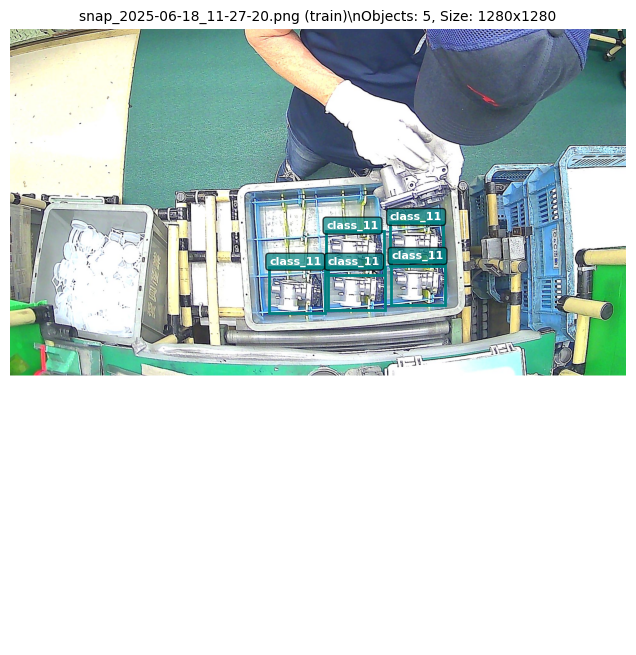

In [135]:
# 実際の画像確認の例

# 利用可能な画像がある場合、最初の画像を詳細表示
if dataset_info['train']['images']:
    print("Training セットの最初の画像を詳細表示:")
    first_image = dataset_info['train']['images'][0]
    print(Path(first_image).name)
    inspect_specific_image(Path(first_image).name, 'train')
elif dataset_info['valid']['images']:
    print("Validation セットの最初の画像を詳細表示:")
    first_image = dataset_info['valid']['images'][0]
    inspect_specific_image(Path(first_image).name, 'valid')
else:
    print("表示可能な画像が見つかりませんでした。")

In [134]:
# まとめと推奨事項

def generate_summary_report():
    """データセット検証のまとめレポートを生成"""
    print("=" * 50)
    print("            データセット検証レポート")
    print("=" * 50)
    
    # 基本統計
    total_train_images = dataset_info['train']['image_count']
    total_valid_images = dataset_info['valid']['image_count']
    total_images = total_train_images + total_valid_images
    
    total_train_labels = dataset_info['train']['label_count']
    total_valid_labels = dataset_info['valid']['label_count']
    total_labels = total_train_labels + total_valid_labels
    
    print(f"\\n📊 基本統計:")
    print(f"   • 総画像数: {total_images}")
    print(f"   • 総ラベル数: {total_labels}")
    print(f"   • Training/Validation 比率: {total_train_images}/{total_valid_images}")
    
    if total_images > 0:
        train_ratio = total_train_images / total_images * 100
        print(f"   • 分割比率: {train_ratio:.1f}% / {100-train_ratio:.1f}%")
    
    # アノテーション統計
    total_train_objects = annotation_analysis['train']['total_objects']
    total_valid_objects = annotation_analysis['valid']['total_objects']
    total_objects = total_train_objects + total_valid_objects
    
    print(f"\\n🎯 アノテーション統計:")
    print(f"   • 総オブジェクト数: {total_objects}")
    print(f"   • Training セット: {total_train_objects} オブジェクト")
    print(f"   • Validation セット: {total_valid_objects} オブジェクト")
    
    # ファイル対応関係
    train_image_stems = {Path(img).stem for img in dataset_info['train']['images']}
    train_label_stems = {Path(lbl).stem for lbl in dataset_info['train']['labels']}
    train_matched = len(train_image_stems & train_label_stems)
    
    valid_image_stems = {Path(img).stem for img in dataset_info['valid']['images']}
    valid_label_stems = {Path(lbl).stem for lbl in dataset_info['valid']['labels']}
    valid_matched = len(valid_image_stems & valid_label_stems)
    
    print(f"\\n🔗 ファイル対応関係:")
    print(f"   • Training セット: {train_matched}/{total_train_images} マッチ")
    print(f"   • Validation セット: {valid_matched}/{total_valid_images} マッチ")
    
    # 推奨事項
    print(f"\\n💡 推奨事項:")
    issues = []
    
    if total_images == 0:
        issues.append("画像ファイルが見つかりません")
    
    if total_labels == 0:
        issues.append("ラベルファイルが見つかりません")
    
    if total_train_images < total_valid_images:
        issues.append("Training セットがValidation セットより少なくなっています")
    
    if train_matched < total_train_images * 0.9:
        issues.append(f"Training セットで対応しないファイルが多数あります ({total_train_images - train_matched}/{total_train_images})")
    
    if valid_matched < total_valid_images * 0.9:
        issues.append(f"Validation セットで対応しないファイルが多数あります ({total_valid_images - valid_matched}/{total_valid_images})")
    
    if total_valid_images < 1:
        issues.append("Validation セットが空です")
    
    if not issues:
        print("   ✅ データセット分割は適切に実行されています")
    else:
        for i, issue in enumerate(issues, 1):
            print(f"   ⚠️  {i}. {issue}")
    
    print(f"\\n📈 次のステップ:")
    print(f"   1. 上記の問題点があれば修正してください")
    print(f"   2. 個別の画像とアノテーションを目視確認してください")
    print(f"   3. クラス分布が適切かを確認してください")
    print(f"   4. YOLO学習用の設定ファイルを確認してください")
    
    print("=" * 50)

# レポートを生成
generate_summary_report()

            データセット検証レポート
\n📊 基本統計:
   • 総画像数: 16
   • 総ラベル数: 8
   • Training/Validation 比率: 14/2
   • 分割比率: 87.5% / 12.5%
\n🎯 アノテーション統計:
   • 総オブジェクト数: 36
   • Training セット: 31 オブジェクト
   • Validation セット: 5 オブジェクト
\n🔗 ファイル対応関係:
   • Training セット: 7/14 マッチ
   • Validation セット: 1/2 マッチ
\n💡 推奨事項:
   ⚠️  1. Training セットで対応しないファイルが多数あります (7/14)
   ⚠️  2. Validation セットで対応しないファイルが多数あります (1/2)
\n📈 次のステップ:
   1. 上記の問題点があれば修正してください
   2. 個別の画像とアノテーションを目視確認してください
   3. クラス分布が適切かを確認してください
   4. YOLO学習用の設定ファイルを確認してください
